## **Project Overview**: 

| <br/><font size="3"><b> Focus </b></font><br/><br/>  | <br/><font size="3"><b> Description </b></font><br/><br/> |
| :-- | :-- |
| <br/><font size="3"> <b>Project Title</b> </font>  <br/><br/>| <br/><font size="3"> M2NIST Image Semantic Segmentation of Digits with FCN-8</font> <br/><br/>|
| <br/><font size="3"> <b>Project Type</b> </font> <br/><br/>| <br/><font size="3">Image Segmentation (Semantic Segmenetation) </font> <br/><br/>|
| <br/><font size="3"><b>Project Objectives</b> </font>  <br/><br/>| <br/><font size="3">1. Train a model to predict semantic segmentations of M2NIST images<br/>  2. Evaluate model performance using various metrics <br/>3. Predict masks/segmentations of M2NIST images using the model and compare predictions with ground-truth masks </font> <br/><br/>|
| <br/><font size="3"> <b>Dataset Overview </b> </font> <br/><br/>| <br/><font size="3"> This dataset provides data images and labeled semantic segmentations captured via CARLA self-driving car simulator. The data which was generated as part of the 2018 Lyft Udacity Perception Challenge consists of **5000** images and their semantic segmentations. </font> <br/><br/>|
| <br/><font size="3"> <b> Model Evaluation Metrics</b> </font> <br/><br/>| <br/><font size="3"> Model Accuracy, Mean Precision, Mean Recall, Mean Specificity, Mean Intersection over Union (mIoU), Mean True Detection Rate (TDR), Mean F1 Score/Dice Co-efficient (TDR) </font> <br/><br/>|
| <font size="3"> <b>Image Segmentation Model Type</b> </font> | <br/><font size="3"> <a href="https://arxiv.org/abs/1411.4038"> <b> FCN-8 Architecture</b></a> </font> <br/><br/>|
| 
<br/>



## **Table of Contents**: 
<font size="3">

- [**1 - Import Required Packages**](#1)

    
- [**2 - Data Preparation**](##2)
    - [2.1 Upload Kaggle API Authentication token
](#2-1)
    - [ 2.2 Download m2nist dataset from Kagle to local storage and unzip
](#2-2)
    - [ 2.3 Load the Data 
](#2-3)
    - [ 2.4 Preprocess Data 
](#2-4)

    
- [**3. Examin the Dataset**](#3)
    - [3.1. An Illustration of the annotation data arrangement](#3-1)
    - [3.2. Dataset Visualization (1): Plot contents of a single dataset entry](#3-2) 
    - [3.3. Inspect the Dataset (2): Plot a batch of example images, along with their corresponding ground truth segmented data](#3-3)   

    
- [**4 - Define the Network's Model**](#4)
    - [4.1. - The Encoder](#4-1)
    - [4.2. - The Decoder](#4-2)
    - [4.3. - Construct the Complete FCN8 Network](#4-3)

    

    
- [**5 - Compile the Model**](#5)
- [**6 - Model Training**](#6)
- [**7 - Inference**](#7)
- [**8 - Visualize inference results**](#8)
- [**9 - Model Evaluation Metrics**](#9)


    
<font>

<a name='1'></a>
## 1. Import Required Packages


In [ ]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import math

<a name='2'></a>
## 2. Data Preparation

<a name='2-1'></a>
### 2.1 Upload Kaggle API Authentication token
 - (only If running in Colab platform)

It is assumed token file named kaggle.json is available for upload.
Click on `Choose Files` and upload it.

Find more details on Kaggle API setup here <a target="_blank" href="https://ronen-halevy.github.io/2021/11/15/kaggle-api-settings.html">here.</a>.


**Notes:**
#### 1. API Authentication token is needed for kaggle dataset upload, which follows.
#### 2.  If running in local platform, it is assumed the token is already arranged.
#### 3. If running within Kaggle Kernel platform - a token is not needed.
 



In [ ]:
# if in colab platform - upload kaggle authentication file
if 'google.colab' in str(get_ipython()):
  from google.colab import files
  from pathlib import Path
  !pip install kaggle
  home = str(Path.home())
  dir='.kaggle'
  file = 'kaggle.json'
  kpath = "{home}/{dir}/".format(home=home, dir=dir)
  try:
    filelist=os.listdir(kpath)
  except Exception as e:
    !mkdir -p ~/.kaggle

  if file not in os.listdir(kpath):
    print('Setup Kaggle API: Upload kaggle.json')
    uploaded = files.upload()
    !mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Setup Kaggle API: Upload kaggle.json


Saving kaggle.json to kaggle.json


<a name='2-2'></a>
### 2.2 Download m2nist dataset from Kagle to local storage and unzip. 
If running in kaggle kernel platform, dataset is available, no need to upload.


#### Data is arranged as 2 numpy arrays files (.npy):

1. **combined.npy** holds the image files containing the multiple MNIST digits. Each image size is **64 x 84** (height x width).

2. **segmented.npy** holds the segmentation masks. Size is also  **64 x 84**.


In [ ]:
dataset_dir = ''
if not os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    import zipfile
    !kaggle datasets download -d farhanhubble/multimnistm2nist
    local_zip = 'multimnistm2nist.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    dataset_dir = '/tmp/'
    zip_ref.extractall(dataset_dir)
    zip_ref.close()
else:
    dataset_dir = '/kaggle/input/multimnistm2nist'

 84% 14.0M/16.6M [00:00<00:00, 33.5MB/s]
100% 16.6M/16.6M [00:00<00:00, 55.4MB/s]


<a name='2-3'></a>
### 2.3 Load the Data

Reshape data, and the channel axis, as required by tensorflow training process.

Divide data by 255, normalizing values to [0, 1]

Split dataset to Train and Test parts. (Train section will later be split farther to Train and Validation)



In [ ]:
segmented = np.load('{dataset_dir}/segmented.npy'.format(dataset_dir=dataset_dir))
_, height, width, n_classes = segmented.shape
combined = np.load('{dataset_dir}/combined.npy'.format(dataset_dir=dataset_dir)).reshape((-1, height, width, 1))/255

combined, test_images, segmented, test_annotations = train_test_split(combined, segmented, test_size=0.1, shuffle=True)

<a name='2-4'></a>
### 2.4 Preprocess Data
Generate batches of tensor image data with real-time data augmentation.



In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10.0,
                                                       width_shift_range=2,
                                                       height_shift_range=2,
                                                       shear_range=0.0,
                                                       zoom_range=0.1,
                                                       data_format='channels_last',
                                                       validation_split=0.1
                                                      )


<a name='3'></a>

## 3. Examin the Dataset

The dataset consists of 2 subsets, stored as 2 numpy arrays:
1. The image data: this numpy array, named `combined`, holds the data example images. Each image consists of 2-3 digits.
2. The anottations data: this numpy array, named `segmented`, holds the `ground truth` for the segmentation results, corresponding to the example images. Each entry of the `segmented` array consists of 11 channels, where each channel corresponds to one of the 11 supported segments: digits 0-9, and blanck pixels semantic segment.

An example which illustrates the `segmented` data arrangement follows.



 


<a name='3-1'></a>
### 3.1 An Illustration of the annotation data arrangement
 
Suppose the dataset contains digit images of size 8 x 9 pixels.
Let's present such an image, with digits `1` and `0` like so:

<img src='https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-1.drawio.png' alt='fcn-9'>

The 3 expected segments are clearly the `1`, the `0` and the background as depicted in the next image:

<img src='https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-1-s.drawio.png' alt='fcn-9'>


Goal is to set semantic segmentation classification per-pixel, i.e. specify pereach pixel, which segment it belongs to- either one of the 10 digits, or to the background.

Accordingly, the network's output layer contains 11 classes, each class corresponds to one of the 11 segments. Per each class, the pixels which correspond to the related segment are `1`, while otherwise pixes are `0`

Following sketches illustrate the expected classification outputs of the 11 classes given above example image as input data. 






Class 1             |  Class 2  |  **Class 3- Class 10** |  **Class 11**
:-------------------------:|:-------------------------: |:-------------------------: |:-------------------------:
![](https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-2.drawio.png)  |  ![](https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-3.drawio.png)  |  ![](https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-4.drawio.png)  |  ![](https://ronen-halevy.github.io/assets/images/image-segmentation/m2nist_image_illustration-5.drawio.png)


**Class 1** Corresponds to digit 0 - the pixels of the `0` segment are set to `1`.

**Class 2** Corresponds to digit 1 - the pixels of the `1` segment are set to `1`.

**Class 3-10** Correspond to digits 2-9 respectively - no pixels are assigned to these classes.

**Class 11** Corresponds to background digits - all background digits are assigned to this class.




<a name='3-2'></a>
### 3.2 Dataset Visualization (1): Plot contents of a single dataset entry
Present a randomly selected input image with it's corresponding 11 channel annotations.

Note that 3 segments are formed - for digits 2, 3 and the background pixels.

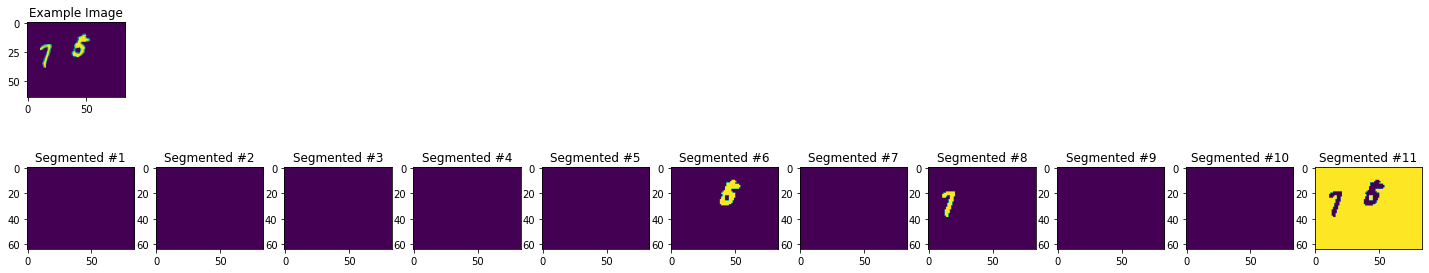

In [ ]:

rand_index = np.random.randint(0,len(combined))
c,s = combined[rand_index], segmented[rand_index]
c=np.squeeze(c, axis=None)
plt.figure(figsize=(25,5))

plt.subplot(2, s.shape[2]+1, 1)
plt.title('Example Image')
plt.imshow(c)

for idx in range(s.shape[2]):
  plt.subplot(2, s.shape[2], s.shape[2]+idx+1)
  plt.title('Segmented #{}'.format(idx+1))
  plt.imshow(s[:,:,idx])


<a name='3-3'></a>
### 3.3 Inspect the Dataset (2): Plot a batch of example images, along with their corresponding `ground truth` segmented data.
 
Now let's take a look at a set of images.
First row shows the listed images, while the second row presents the corresponding anottations, where all channels are integrated to a single channel (np.argmax composes the resultant image by selecting the maximal value pixels amongs all 11 channel).

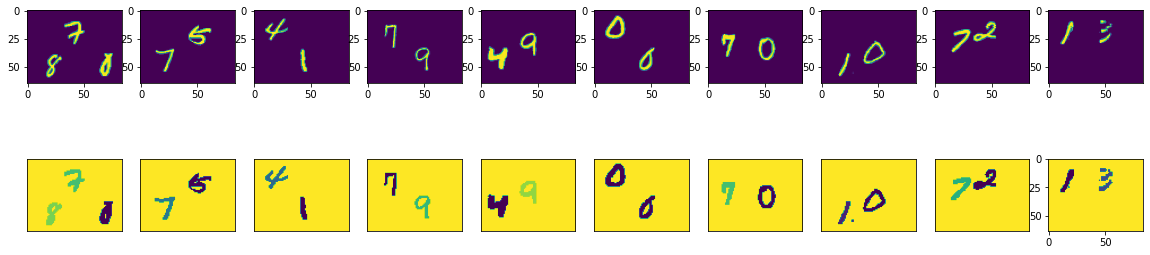

In [ ]:
plt.figure(figsize=(20, 5))

N = min(10, segmented.shape[0])
for idx in range(N):
  plt.yticks([])
  plt.xticks([])
  
  plt.subplot(2, N, idx+1)
  c=np.squeeze(c, axis=None)
  plt.imshow(np.squeeze(combined[idx]))
  plt.subplot(2, N, N+idx+1)
  plt.imshow(np.argmax(segmented[idx], axis=2))

<a name='4'></a>
## 4. Define the Network's Model
Here we use FCN-8, as presented in <a href="https://arxiv.org/abs/1411.4038">"Fully Convolutional Networks for Semantic Segmentation" </a> by Long, Shelhamer and Darrell.

***FCN-8 Block Diagram***


<img src='https://ronen-halevy.github.io/assets/images/image-segmentation/fcn-8.drawio.png' alt='fcn-9'>


FCN-8 consists of a 5 layered encoder which is resposible for the feature detection, followed by a decoder which expands the features back to it's original side, upsampling using Conv2D-Transpose. 
To preserve lower level features, `Pool 3` and `Pool 4` layers outputs are accumulated with the final layer's output, (aka skips), as depicted in the block diagram.

Let's construct the encoder and decoder!


<a name='4-1'></a>
### 4.1 The Encoder 

Each encoder's stage consists of:

- Conv2D

- LeakyReLU

- Conv2D

- LeakyReLU

- MaxPooling2D

- BatchNormalization





In [ ]:
IMAGE_ORDERING = 'channels_last'
def fcn8_downsampling(input_height=64, input_width=84):
    inputs=tf.keras.layers.Input((input_height, input_width,1))
  
    # Resize images so that downsampling division results will be integers - i.e. dimensions should be divisible by 2**5.
    
    zero_padding_height = math.ceil(input_height/32)*32 - input_height
    zero_padding_width = math.ceil(input_width/32)*32 - input_width
    
    x=tf.keras.layers.ZeroPadding2D(((0, 0), (zero_padding_height, zero_padding_width)))(inputs)
    layers = []

    # Build the encoder in a loop, running on number of filters. Each stage
    for filters in [32,64,128,256,256]:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', data_format=IMAGE_ORDERING)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', data_format=IMAGE_ORDERING)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        layers.append(x)
   
    # We add an extra set of convolutions - no pooling attached.
  
    for idx, params in enumerate([{'f': 512, 'k': 7} ,{'f': 512, 'k': 1}]):
        x = tf.keras.layers.Conv2D(filters=params['f'], kernel_size=params['k'] ,strides=1 , activation='relu' , padding='same', name="conv{i}".format(i=idx), data_format=IMAGE_ORDERING)(x)
        x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(x)
  
    layers.pop()
    layers.append(x)

    return layers, inputs




<a name='4-2'></a>
### 4.2 The Decoder

- This code implements the Decoder, as depicted in the above block diagram. 
- Input `conv` is a list with encoder's 5 layers outputs. `n_classes` is the number of output classes, 11 in current case.
- Number of filters for all layers is n_classes - which is the number of semantic segments.
- Output stage is a `softmax`, which normalizes the  output to probability distribution.

In [ ]:
def fcn8_upsampling(convs, n_classes):
    _,_,f3,f4,f5 = convs
    x = f5
    
    for filters, x2 in [(n_classes, f4),(n_classes, f3)]:
        x = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(x)
        x = tf.keras.layers.Cropping2D(cropping=(1,1))(x)

        x2 = ( tf.keras.layers.Conv2D(n_classes , kernel_size=( 1 , 1 ) , activation='relu' , padding='same'))(x2)
        x = tf.keras.layers.Add()([x, x2])

    # upsample up to the size of the original image
    x = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(x)
    x = tf.keras.layers.Cropping2D(((0, 0), (0, 96-width)))(x)

    # append a sigmoid activation
    x = (tf.keras.layers.Activation('softmax'))(x)
    return x

<a name='4-3'></a>
### 4.3 Construct the Complete FCN8 Network

In [ ]:
convs, inputs  = fcn8_downsampling()
dec_op = fcn8_upsampling(convs, n_classes)
model = tf.keras.Model(inputs = inputs, outputs = dec_op)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

<a name='5'></a>
## 5. Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

<a name='6'></a>
### 6. Model Training## 

Dataset is arranged as an ImageDataGenerator, which generates batches of tensor image data with real-time data sugmentation.
Validation split is 0.1 (while training is 0.9).

In [ ]:
epochs = 70
batch_size = 50

model.fit_generator(zip(datagen.flow(combined, batch_size=batch_size, subset='training', seed=1), datagen.flow(segmented, batch_size=batch_size, subset='training', seed=1)),
                    epochs=epochs, 
                    steps_per_epoch = len(combined)//batch_size,
                    validation_data=zip(datagen.flow(combined, batch_size=batch_size, subset='validation', seed=1), datagen.flow(segmented, batch_size=batch_size, subset='validation', seed=1)),
                    validation_steps=50,
                    verbose=2
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (4050, 64, 84, 11) (11 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (450, 64, 84, 11) (11 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
90/90 - 312s - loss: 0.5892 - accuracy: 0.8284 - val_loss: 0.6403 - val_accuracy: 0.9419 - 312s/epoch - 3s/step
Epoch 2/30
90/90 - 313s - loss: 0.2223 - accuracy: 0.9422 - val_loss: 0.4879 - val_accuracy: 0.9420 - 313s/epoch - 3s/step
Epoch 3/30
90/90 - 319s - loss: 0.1902 - accuracy: 0.9437 - val_loss: 0.2955 - val_accuracy: 0.9418 - 319s/epoch - 4s/step
Epoch 4/30
90/90 - 322s - loss: 0.1612 - accuracy: 0.9470 - val_loss: 0.2229 - val_accuracy: 0.9420 - 322s/epoch - 4s/step
Epoch 5/30
90/90 - 330s - loss: 0.1289 - accuracy: 0.9555 - val_loss: 0.1999 - val_accuracy: 0.9429 - 330s/epoch - 4s/step
Epoch 6/30
90/90 - 334s - loss: 0.1001 - accuracy: 0.9646 - val_loss: 0.1100 - val_accuracy: 0.9597 - 334s/epoch - 4s/step
Epoch 7/30
90/90 - 328s - loss: 0.0812 - accuracy: 0.9703 - val_loss: 0.0978 - val_accuracy: 0.9641 - 328s/epoch - 4s/step
Epoch 8/30
90/90 - 319s - loss: 0.0727 - accuracy: 0.9726 - val_loss: 0.0794 - val_accuracy: 0.9710 - 319s/epoch - 4s/step
Epoch 9/30
90/90

<a name='7'></a>
## 7. Inference

Let's run inference using the test dataset section.


In [ ]:
batch_size = test_images.shape[0]
test_images_batch, test_annotations_batch = next(datagen.flow((test_images,test_annotations), batch_size=batch_size, subset='validation'))
results = model.predict_on_batch(test_images_batch)

<a name='8'></a>
## 8. Visualize inference results

Show test images vs ground truth annotations vs prediction results.
Images from display are randomly selected from the entire test set.


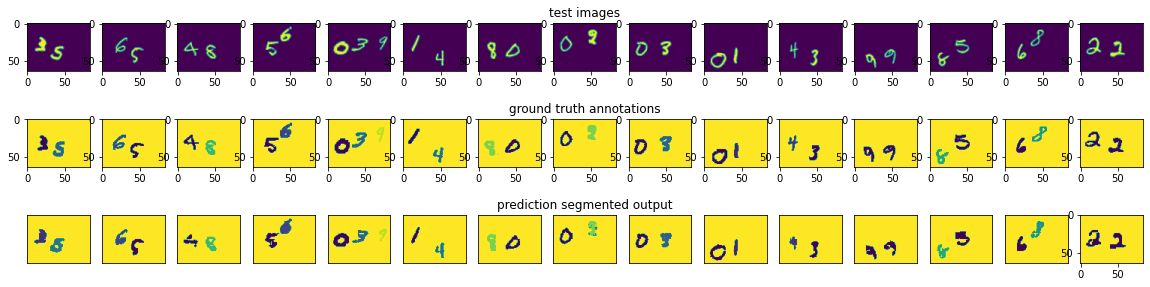

In [ ]:
import random

max_display_images = 15

plt.figure(figsize=(20, 5))

n = min(test_images_batch.shape[0], max_display_images)
test_indices_for_display = random.sample(range(1, test_images_batch.shape[0]), n)

for idx, display_index in enumerate(test_indices_for_display):
  plt.yticks([])
  plt.xticks([])
  plt.subplot(3, N, idx+1)

  plt.imshow(test_images_batch[display_index,:,:,0])
  if idx == int(N/2):
    plt.title('test images')
  plt.subplot(3, N, N+idx+1)
  plt.imshow(np.argmax(test_annotations_batch[display_index], axis=2))
  if idx == int(N/2):
    plt.title('ground truth annotations')
  plt.subplot(3, N, 2*N+idx+1)
  plt.imshow(np.argmax(results[display_index], axis=2))
  if idx == int(N/2):
    plt.title('prediction segmented output')

 


<a name='9'></a>
## 9. Model Evaluation Metrics



\\(iou = \frac{area\ of\ overlap}{area\ of\ union}\\)

\\( dice\ scor = 2 * \frac{area\ of\ overlap}{combined\ area}\\)



In [ ]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    # print(i, intersection, y_true_area, y_true_area)
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(test_annotations_batch, axis=3), np.argmax(results, axis=3))

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou, cls_wise_dice_score)):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")

### Compute IOU Score and Dice Score of your model

## Save the Model

Once you're satisfied with the results, you will need to save your model so you can upload it to the grader in the Coursera classroom. After running the cell below, please look for `student_model.h5` in the File Explorer on the left and download it. Then go back to the Coursera classroom and upload it to the Lab item that points to the autograder of Week 3.

In [ ]:
model.save("model.h5")

In [ ]:
# You can also use this cell as a shortcut for downloading your model
# from google.colab import files
files.download("model.h5")

**Congratulations on completing this assignment on image segmentation!**